In [1]:
# Points à discuter avec Corentin:
# 1. Méthodes à comparer :
    # a) Méthode de traitement de texte (tf-idf-supervisée et une méthode non supervisée (par ex lda et lda vis)), et
    # b) méthode de prédiction : rf seulement (XGBOOST ne gère pas quand y a n-dimensions)
        # Alternative possible one vs rest (on entraîne un des Tags vs les autres)

# Dans cet exercice : 
    # Approche supervisée = retrouver les tags 
    # Approche non supervisée = prévoir des tags. On ne passe pas par un dataset déjà crée : on crée un tag à partir du texte
        # on peut utiliser : nmf (non negative matrice factorisation) : classement par topics (définis = clusters)
        # lda (latent dirichlet allocation) : assez proche de nmf. 
        # Essayer ldavis qui permet de visualiser les topics générés par lda


# 2. Elaboration base line (mesure performances) : J'ai réussi si je transforme y en table de 1 dimension
    # Est ce ok de procéder comme tel pour la mesure de la perf ? etant entendu que pour la prédiction, je garde
    # y en n-dimensions : ce qui a été choisi numpy.argmin() / numpy.argmax() ==> Sans ce cas pas vraiment le bon choix
    # Sinon, comment on fait ?
# https://scikit-learn.org/stable/modules/model_evaluation.html
# Multilabel
# Accuracy : Compte le score comme OK, si on a prédit correctement l'ensemble des scores : assez conservatif
# On peut se construire sa métrique
# Proportion des tags prédits vs ceux à l'origine

# 3. Output de la prédiction : un peu comme pour le projet de reco de ciné, on va chercher l'indice de la
    # Questionnaire : on saisit le titre et le corps du texte
    # En réponse, on obtient un ou plusieurs Tags Est ce bien cela ?

# Pour suivre les modifications du code final à déployer, 
# utiliser un logiciel de gestion de versions, par exemple Git.
# ==>  A mettre en place maintenant

import warnings
warnings.simplefilter("ignore")
warnings.warn("deprecated", DeprecationWarning)
warnings.simplefilter("ignore")

In [3]:
# Etape 1 : import librairie et données sources
import pandas as pd
import numpy as np
df = pd.read_csv("P6QueryResults5.csv", sep=",")

In [4]:
# Etape 2 : Creation de la matière sur laquelle on va travailler

# Rappel : L'objectif consiste à Prédire des Tags, sur la base :
# Des champs 'Body' et 'Title' qui constituent la variable X
# Du champs 'Tags' qui constitue la variable Y à prédire
df['Text'] = df['Body'].astype(str) + df['Title'].astype(str)
df['Tags'] = df['Tags'].astype(str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Id      50000 non-null  int64 
 1   Body    50000 non-null  object
 2   Title   49999 non-null  object
 3   Tags    50000 non-null  object
 4   Text    50000 non-null  object
dtypes: int64(1), object(4)
memory usage: 1.9+ MB


In [5]:
# Etape 3 : Import librairie pour nettoyage texte et tf-idf
import re
import nltk
import pickle
from nltk.corpus import stopwords
from bs4 import BeautifulSoup

In [6]:
# Définition des X et y
X, y = df.Text, df.Tags

In [7]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;?*]')
BAD_SYMBOLS_RE1 = re.compile('[^0-9a-z #+_-]')
STOPWORDS = list((stopwords.words('english')))

def text_prepare_WithSoup(text, join_symbol):
    """
        text: a string

        return: modified initial string
    """
    # 1. Remove HTML
    text = BeautifulSoup(text,features="lxml").get_text()
    
    # lowercase text
    text = text.lower()

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text,)

    # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(BAD_SYMBOLS_RE1, " ", text)
    text = re.sub(r'\s+', " ", text)

    # delete stopwords from text
    text = f'{join_symbol}'.join(
        [i for i in text.split() if i not in STOPWORDS])

    return text


tests = ["SQL Server - any equivalent of Excel's CHOOSE function VB.NET. ?",
         "How to free c++ memory vector<int> * arr?"]
for test in tests:
    print(text_prepare_WithSoup(test, ' '))

sql server - equivalent excel choose function vb net
free c++ memory vector arr


In [8]:
BAD_SYMBOLS_RE2 = re.compile('[^0-9a-z .#+_-]') # A la différence de 'BAD_SYMBOLS_RE2', ici, on garde le '.'
# 'VB.NET' devient 'vb.net'
def text_prepare_NoSoup(text, join_symbol):
    """
        text: a string

        return: modified initial string
    """
    # lowercase text
    text = text.lower()

    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = re.sub(REPLACE_BY_SPACE_RE, " ", text,)

    # delete symbols which are in BAD_SYMBOLS_RE from text
    text = re.sub(BAD_SYMBOLS_RE2, " ", text)
    text = re.sub(r'\s+', " ", text)

    # delete stopwords from text
    text = f'{join_symbol}'.join(
        [i for i in text.split() if i not in STOPWORDS])

    return text
for test in tests:
    print(text_prepare_NoSoup(test, ' '))

sql server - equivalent excel choose function vb.net.
free c++ memory vector int arr


In [9]:
documents = [text_prepare_WithSoup(X, ' ') for X in X]
y_cleaned = [text_prepare_NoSoup(y, ' ') for y in y]

In [10]:
X[0]

'<p>I want to use a <code>Track-Bar</code> to change a <code>Form</code>\'s opacity.</p>\n<p>This is my code:</p>\n<pre class="lang-cs prettyprint-override"><code>decimal trans = trackBar1.Value / 5000;\nthis.Opacity = trans;\n</code></pre>\n<p>When I build the application, it gives the following error:</p>\n<blockquote>\n<p>Cannot implicitly convert type <code>decimal</code> to <code>double</code></p>\n</blockquote>\n<p>I have tried using <code>trans</code> and <code>double</code> but then the <code>Control</code> doesn\'t work. This code worked fine in a past VB.NET project.</p>\nConvert Decimal to Double'

In [11]:
documents[0]

'want use track-bar change form opacity code decimal trans trackbar1 value 5000 opacity trans build application gives following error cannot implicitly convert type decimal double tried using trans double control work code worked fine past vb net project convert decimal double'

In [12]:
y[50:65]

50                                  <c++><berkeley-db>
51                                <svn><collaboration>
52                     <c#><.net><sorting><dictionary>
53            <sql><database><oracle><version-control>
54                                     <security><php>
55                     <c++><oop><class><nested-class>
56                          <language-agnostic><types>
57                                       <python><xml>
58         <string><language-agnostic><cross-platform>
59                                 <email><email-spam>
60    <java><generics><warnings><casting><type-safety>
61                                    <search><lucene>
62                       <ios><objective-c><landscape>
63                                          <com><vb6>
64       <internet-explorer><windows-mobile><pocketpc>
Name: Tags, dtype: object

In [13]:
y_cleaned [50:65]

['c++ berkeley-db',
 'svn collaboration',
 'c# .net sorting dictionary',
 'sql database oracle version-control',
 'security php',
 'c++ oop class nested-class',
 'language-agnostic types',
 'python xml',
 'string language-agnostic cross-platform',
 'email email-spam',
 'java generics warnings casting type-safety',
 'search lucene',
 'ios objective-c landscape',
 'com vb6',
 'internet-explorer windows-mobile pocketpc']

In [14]:
# Etape 5 : Conversion des données textuelles et valeur numériques
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = vectorizer.fit_transform(documents).toarray()

In [15]:
vectorizer = CountVectorizer(max_features=50, 
                             #min_df=0.05, 
                             max_df=0.85, 
                             stop_words=stopwords.words('english'))
y = vectorizer.fit_transform(y_cleaned).toarray()

In [16]:
X.shape

(50000, 1500)

In [17]:
X[0]

array([0, 0, 0, ..., 0, 0, 0])

In [18]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [19]:
# Etape 6 : Process TF-IDF
# 6.1 Pour X
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X = tfidfconverter.fit_transform(X).toarray()

In [20]:
#  6.2 Pour y : Pour y, il faut seulement CountVectorizer (avoir des valeurs binaires)
vectorizer = CountVectorizer(analyzer="word",
                             tokenizer=None,
                             preprocessor=None,
                             stop_words=None,
                             max_features=50)
y = vectorizer.fit_transform(y_cleaned)
# Conversion de y en array (plus facile de travailler avec)
y = y.toarray()

In [21]:
X.shape

(50000, 1500)

In [22]:
X[0]

array([0., 0., 0., ..., 0., 0., 0.])

In [23]:
y.shape

(50000, 50)

In [24]:
y[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [25]:
# Etape 7 : Mise en place des ensemble train test
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [26]:
# *** ICI *** Il faut transformer la matrice y_pred en liste 1 dimension, 
    # sinon grid search, les calculs de perf et de matrice de confusion ne fonctionnent pas
    # L'idée est de faire une base line avec cette matrice de dimension 1
    # Mais le modèle sera bien exécuté avec la matrice de dimension n : le modèle predn le nom '_max'
import numpy as np
y_test_max= np.argmax(y_test, axis=1) # On prend les valeurs max : si je prends une autre méthode (argmin) ça change ?
y_train_max = np.argmax(y_train, axis=1)

In [27]:
# Etape 8 : Entrainement classification des textes et prédiction des tags
# Préalablement, on fait un GridSearchCV pour recherche paramètres à optimiser
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

param_gridRF = {"max_depth": [3, 5],  # Maximum number of levels in tree
                "min_samples_split": [3, 10],# Minimum number of samples required to split a node
                }

rfc = RandomForestClassifier(random_state=42, oob_score=True)

In [28]:
# Vérification : on plus qu'une seule dimension
y_test_max[0]

0

In [29]:
from sklearn.metrics import accuracy_score
modelrf_max = GridSearchCV(rfc,
                       param_gridRF,
                       n_jobs=-1,
                       cv=5
                       )
classifier_max = modelrf_max.fit(X_train, y_train_max)

In [30]:
print(classifier_max.best_params_)
# Pas de raison que le grid search ne fonctionne pas pour un y n-dimensions

{'max_depth': 5, 'min_samples_split': 10}


In [31]:
# Prédiction sur la base des meilleurs paramètres
classifier_max = RandomForestClassifier(max_depth = 5, min_samples_split = 10)
classifier_max.fit(X_train, y_train_max)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=5, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=10,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [32]:
# Prédiction modèle y = 1 dimension pour obtenir les performances
y_pred_max = classifier_max.predict(X_test)

Confusion matrix, without normalization
[[4151    0    0 ...    0    0    0]
 [ 163    0    0 ...    0    0    0]
 [ 202    0    0 ...    0    0    0]
 ...
 [  72    0    0 ...    0    0    0]
 [ 144    0    0 ...    0    0    0]
 [ 129    0    0 ...    0    0    0]]
Normalized confusion matrix
[[0.99879692 0.         0.         ... 0.         0.         0.        ]
 [0.99390244 0.         0.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 ...
 [1.         0.         0.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]
 [1.         0.         0.         ... 0.         0.         0.        ]]


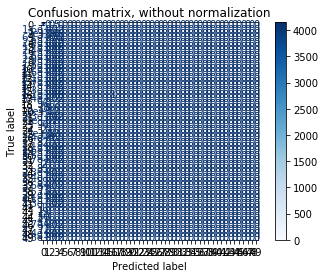

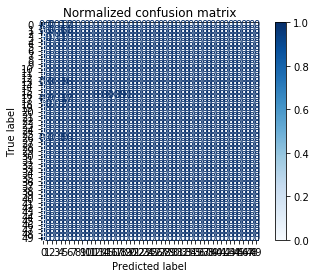

In [33]:
# 1. Matrice de confusion pour méthode rf
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt
# Plot non-normalized confusion matrix

titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
for title, normalize in titles_options:
    disp = plot_confusion_matrix(modelrf_max, X_test, y_test_max,
                                 # display_labels=range(5),
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)

    print(title)
    print(disp.confusion_matrix)

plt.show()

In [34]:
# Etape 9 : Evaluation du modèle
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
print(confusion_matrix(y_test_max,y_pred_max))
print(classification_report(y_test_max,y_pred_max))
print(accuracy_score(y_test_max, y_pred_max)) # Devrait accepter y n-dimensions

[[4149    0    0 ...    0    0    0]
 [ 162    0    0 ...    0    0    0]
 [ 202    0    0 ...    0    0    0]
 ...
 [  72    0    0 ...    0    0    0]
 [ 144    0    0 ...    0    0    0]
 [ 129    0    0 ...    0    0    0]]
              precision    recall  f1-score   support

           0       0.28      1.00      0.44      4156
           1       0.00      0.00      0.00       164
           2       0.00      0.00      0.00       202
           3       0.79      0.18      0.29       692
           4       0.00      0.00      0.00       219
           5       0.00      0.00      0.00       172
           6       0.00      0.00      0.00       235
           7       0.00      0.00      0.00       146
           8       0.00      0.00      0.00       286
           9       0.00      0.00      0.00       129
          10       0.00      0.00      0.00       121
          11       0.00      0.00      0.00       155
          12       0.00      0.00      0.00       209
          13   

In [35]:
# *** ICI *** Effectuer methode BERT et comparer avec TF-IDF

In [ ]:
# Maintenant que l'on a les paramètres optimaux et une baseline, on va exécuter le modèle
# mais avec y en n-dimensions

In [ ]:
# Prédiction sur la base des meilleurs paramètres
modelrf = RandomForestClassifier(max_depth=5, min_samples_split=10)
modelrf.fit(X_train, y_train)

In [ ]:
# Prédiction modèle y = 1 dimension pour obtenir les performances
y_pred_rf = modelrf.predict(X_test)

In [ ]:
# Etape 10 : Sauvegarde du modèle devra être adapté si BERT = meilleur
with open('P6text_classifier', 'wb') as picklefile:
    pickle.dump(modelrf,picklefile)

In [ ]:
# Etape 11 : Chargement du modèle pour prédire les tags et évaluer sa performance
with open('P6text_classifier', 'rb') as training_model:
    model = pickle.load(training_model)